In [1]:
import polars as pl
import pandas as pd

pl.Config.set_fmt_str_lengths(200)
pl.Config.set_fmt_float("full")

polars.config.Config

In [2]:
# load perp_margin_vol
perp_margin_vol = pl.read_csv("data/perp_margin_vol.csv")

In [3]:
# convert timestamp to datetime
perp_margin_vol = perp_margin_vol.with_columns(
    pl.col("timestamp").str.to_date(format='%Y-%m-%d')
)

In [4]:
# filter data for dates between 3/1/23 and 5/31/23
perp_margin_vol = perp_margin_vol.filter(
    (pl.col("timestamp") >= pl.date(2023,4,1))
)

In [5]:
perp_margin_vol.head(5)

timestamp,token,volume,protocol
date,str,f64,str
2023-07-01,"""LINK""",998398.9461109834,"""GMX"""
2023-07-01,"""WETH""",44020376.9708315,"""GMX"""
2023-07-01,"""UNI""",2270084.2464602906,"""GMX"""
2023-07-01,"""WBTC""",8127496.180891069,"""GMX"""
2023-07-01,"""AVAX""",1529145.5261540012,"""GMX"""


In [6]:
def standardize_token_names(df: pl.DataFrame, target_symbol_list: list[str], output_symbol: str) -> pl.DataFrame:
    """takes a list of symbols that should be standardized to a single symbol and returns a dataframe with the standardized symbols"""
    for symbol in target_symbol_list:
        df = df.with_columns(
            pl.when(pl.col('token') == symbol).then(pl.lit(output_symbol)).otherwise(pl.col('token')).alias('token')
        )
    
    return df

In [7]:
# if token starts with lowercase s or lowercase v, then drop the letter
no_synth_tokens_df = perp_margin_vol.with_columns(
    pl.when(pl.col('token').str.slice(0,1) == 's').then(pl.col('token').str.slice(1,)).otherwise(pl.col('token')).alias('token')
)

no_perp_tokens_df = no_synth_tokens_df.with_columns(
    pl.when(pl.col('token').str.slice(0,1) == 'v').then(pl.col('token').str.slice(1,)).otherwise(pl.col('token')).alias('token')
)

In [8]:
# remove eth and btc variation names
no_eth_variation_df = standardize_token_names(no_perp_tokens_df, ['ETH'], 'WETH')
no_btc_variation_df = standardize_token_names(no_eth_variation_df, ['BTC', 'BTC.b'], 'WBTC')

# remove "OTHER (<$1.5M)" and "Other (Volume Pair <$1M)" from token
perp_margin_token_vol = no_btc_variation_df.filter(
    (pl.col('token') != 'OTHER (<$1.5M)') & (pl.col('token') != 'Other (Volume Pair <$1M)') & (pl.col('token') != 'Other (Volume <$1M)')
)


### Plot

In [9]:
# convert to pandas
perp_margin_token_vol_pd = perp_margin_token_vol.to_pandas()

In [11]:
# remove timestamp
perp_margin_token_vol_pd = perp_margin_token_vol_pd.drop(columns=['timestamp'])

# group by token, protocl and sum
perp_margin_token_vol_pd = perp_margin_token_vol_pd.groupby(['token', 'protocol']).sum()

In [12]:
# reset index for pivot
perp_margin_token_vol_pd = perp_margin_token_vol_pd.reset_index()

In [13]:
# pivot blockchain column to column headers. Make token the index
pivot_df = perp_margin_token_vol_pd.pivot(index='token', columns='protocol', values='volume')

In [14]:
# create a new sum column
pivot_df['sum'] = pivot_df.sum(axis=1)

In [15]:
# sort
pivot_df = pivot_df.sort_values(by='sum', ascending=True)

In [16]:
pivot_df = pivot_df.tail(15)

In [17]:
pivot_df

protocol,GMX,GNS,KWENTA,LEVEL,MUX,PERP,VERTEX,sum
token,,,,,,,,
DOGE,NaN,1.412905e+08,1.903912e+07,NaN,NaN,5.462748e+07,NaN,2.149571e+08
LINK,9.325772e+07,4.112891e+07,5.774598e+07,NaN,NaN,3.665972e+07,NaN,2.287923e+08
AUD,NaN,2.461337e+08,7.670003e+07,NaN,NaN,NaN,NaN,3.228337e+08
BNB,NaN,1.049613e+08,1.091838e+08,3.291978e+07,2.579595e+07,6.980051e+07,1.536924e+07,3.580305e+08
MATIC,NaN,1.525475e+08,1.378246e+08,NaN,NaN,7.406165e+07,1.600381e+07,3.804376e+08
SOL,NaN,1.401529e+08,1.337040e+08,NaN,NaN,8.182732e+07,3.690222e+07,3.925865e+08
AVAX,2.245544e+08,3.090284e+07,9.198092e+07,NaN,3.301120e+07,4.452587e+07,NaN,4.249753e+08
OP,NaN,NaN,2.541302e+08,NaN,7.036236e+07,1.612489e+08,NaN,4.857415e+08
XAU,NaN,1.190183e+08,5.223342e+08,NaN,NaN,NaN,NaN,6.413525e+08


In [18]:
# get top 5 largest sum value rows
pivot_df = pivot_df.tail(5)

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import thanefield_charting as tc

# Format the y-axis tick labels
def format_y_ticks(value, pos):
    if value >= 1e9:
        return f'${value / 1e9:.1f}B'
    elif value >= 1e6:
        return f'${value / 1e6:.1f}M'
    elif value >= 1e3:
        return f'${value / 1e3:.1f}K'
    else:
        return f'${value:.0f}'


In [20]:
# fill NaN values with 0
pivot_df = pivot_df.fillna(0)

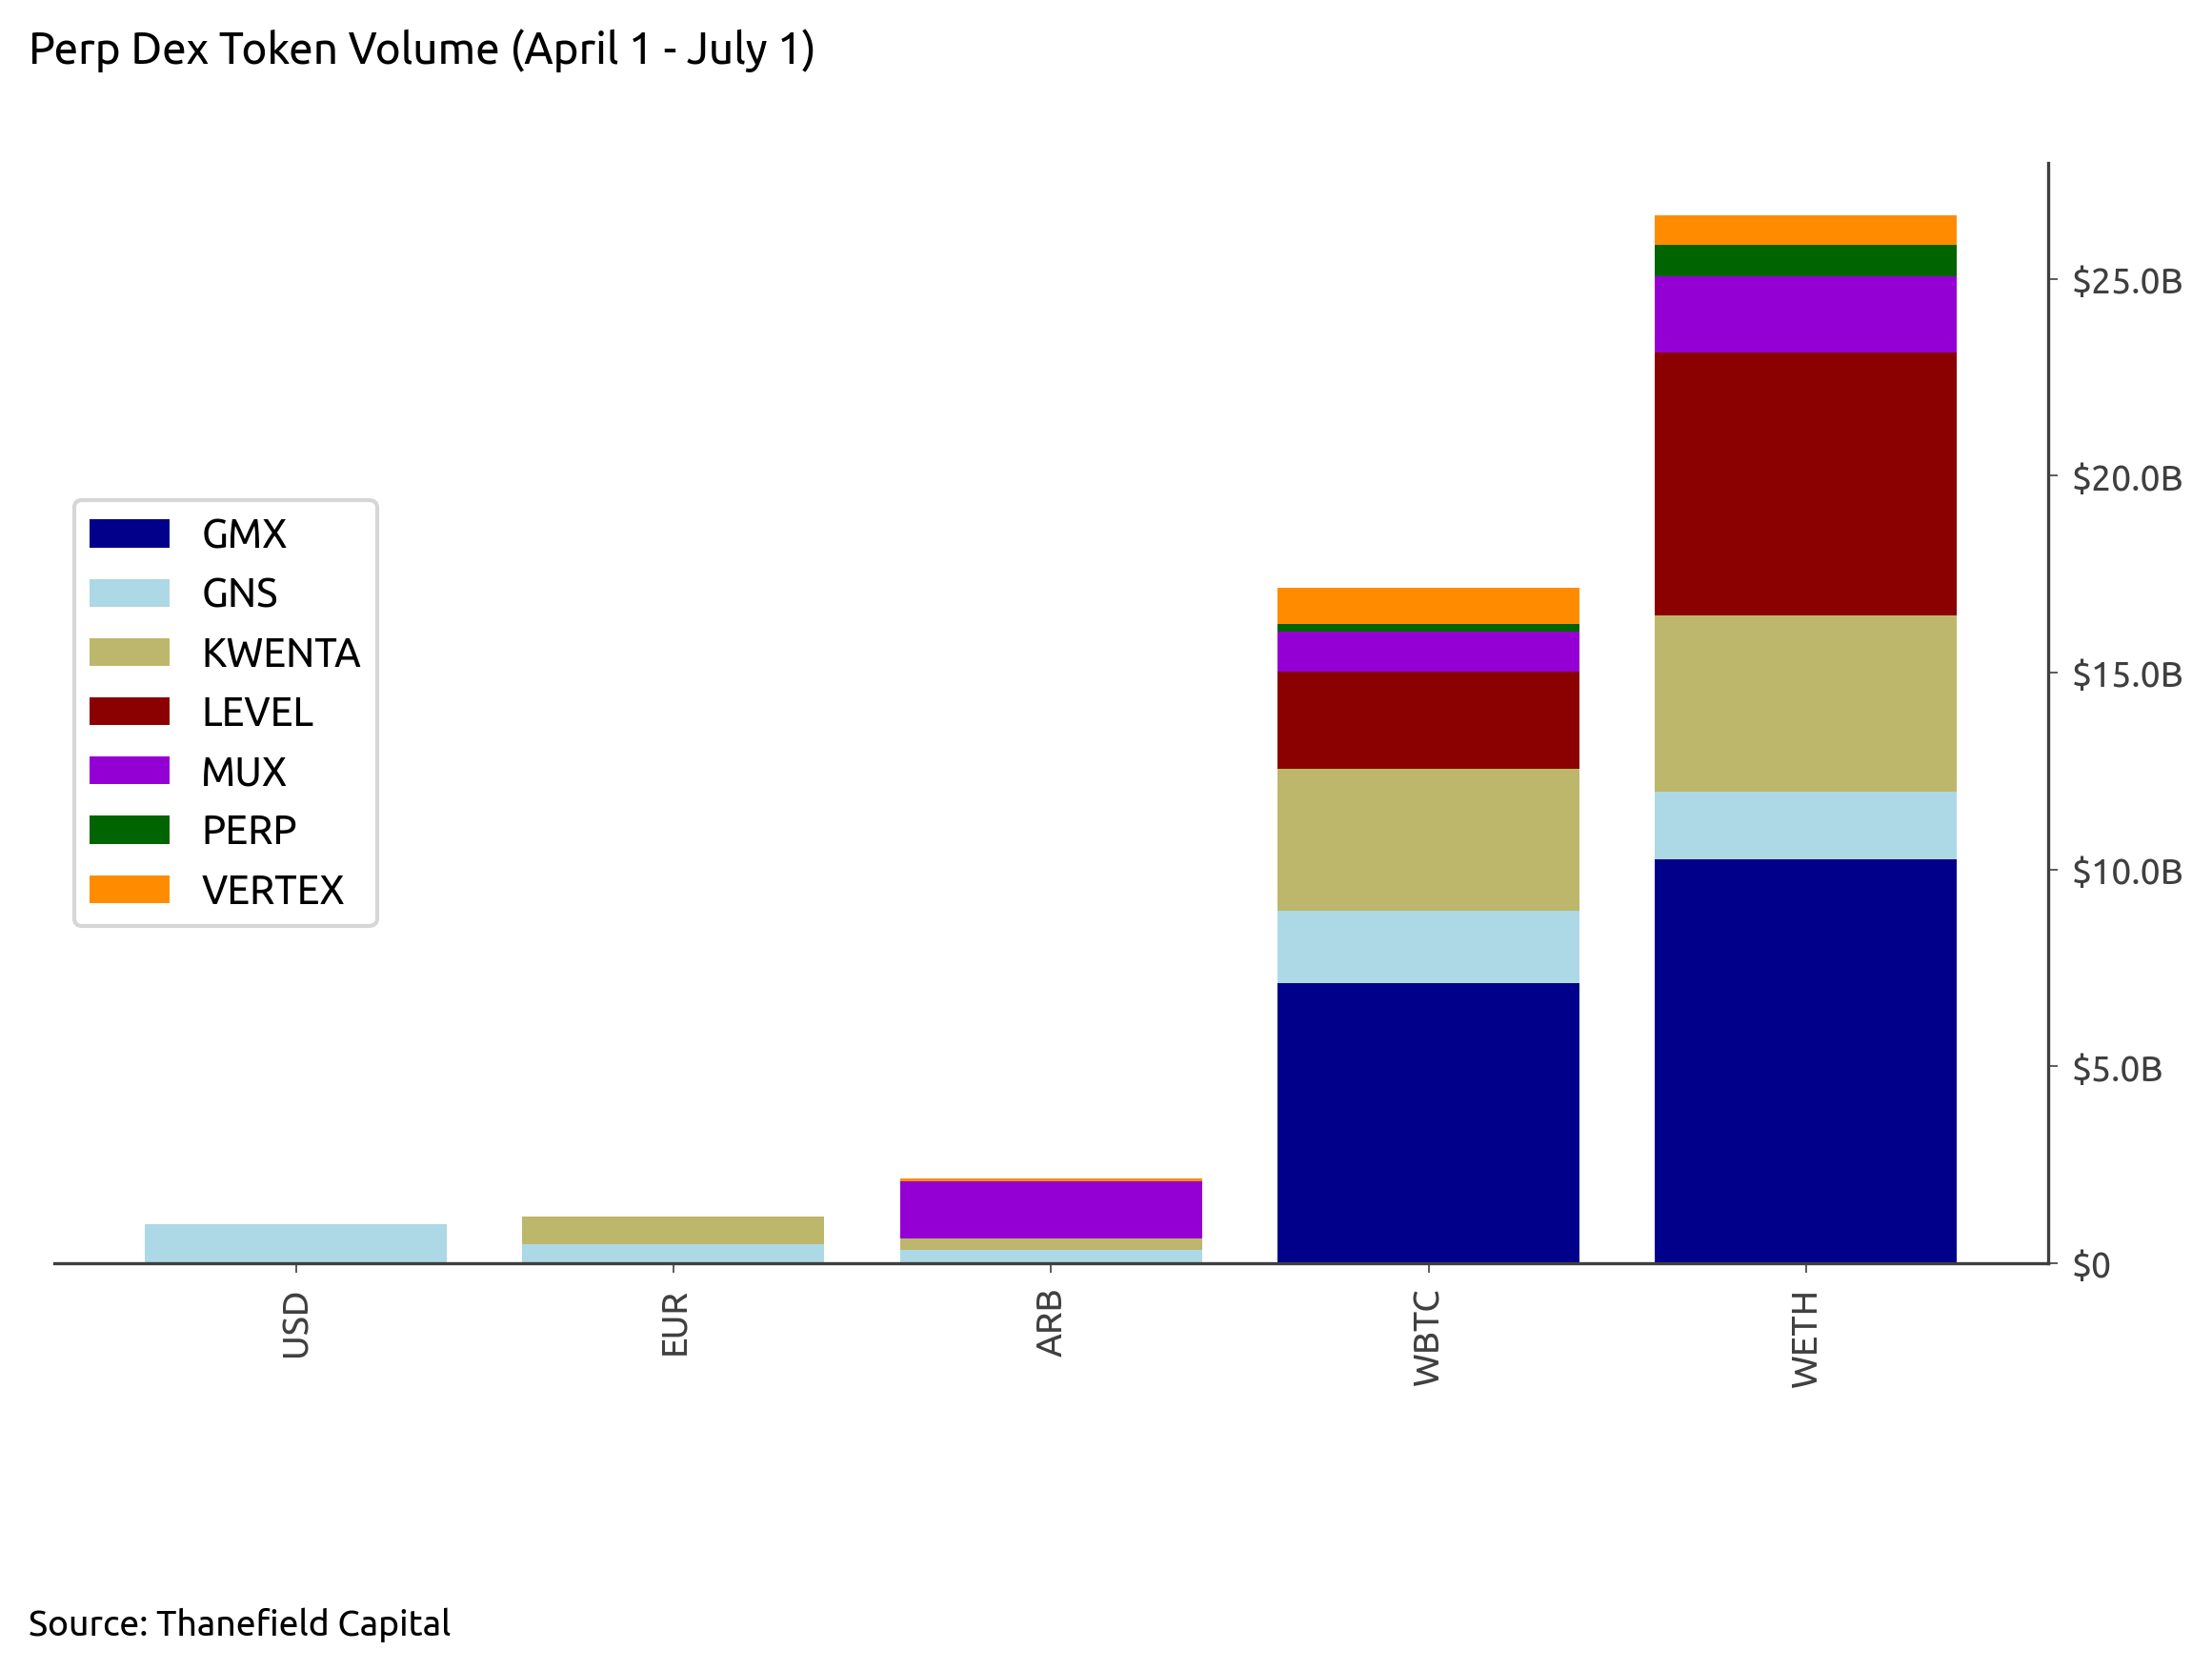

<Figure size 640x480 with 0 Axes>

In [22]:
# note each token has over 1b volume
fig, ax = tc.chart('Perp Dex Token Volume (April 1 - July 1)', dates=False)

ax.bar(pivot_df.index, pivot_df['GMX'], color='darkblue', label='GMX')
ax.bar(pivot_df.index, pivot_df['GNS'], bottom=pivot_df['GMX'], color='lightblue', label='GNS')
ax.bar(pivot_df.index, pivot_df['KWENTA'], bottom=pivot_df['GMX']+pivot_df['GNS'], color='darkkhaki' , label='KWENTA')
ax.bar(pivot_df.index, pivot_df['LEVEL'], bottom=pivot_df['GMX']+pivot_df['GNS']+pivot_df['KWENTA'], color='darkred', label='LEVEL')
ax.bar(pivot_df.index, pivot_df['MUX'], bottom=pivot_df['GMX']+pivot_df['GNS']+pivot_df['KWENTA']+pivot_df['LEVEL'], color='darkviolet', label='MUX')
ax.bar(pivot_df.index, pivot_df['PERP'], bottom=pivot_df['GMX']+pivot_df['GNS']+pivot_df['KWENTA']+pivot_df['LEVEL']+pivot_df['MUX'], color='darkgreen', label='PERP')
ax.bar(pivot_df.index, pivot_df['VERTEX'], bottom=pivot_df['GMX']+pivot_df['GNS']+pivot_df['KWENTA']+pivot_df['LEVEL']+pivot_df['MUX']+pivot_df['PERP'], color='darkorange', label='VERTEX')


# Apply the custom formatting function to the y-axis
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_y_ticks))

# formatting
tc.legend(ax)
# tc.set_xmargin(ax, margin=.05)
# plt.tight_layout()
plt.xticks(rotation=90)
plt.legend(loc='center left')
plt.show()
# save chart
tc.save('charts/perp_dex_total_token_vol.png')